In [1]:
import torch
from torch import nn
%load_ext autoreload
%autoreload 2

from torchvision.transforms import ToTensor


In [2]:
from torchvision import datasets


train_data  = datasets.FashionMNIST(
    root= 'data',
    train= True,
    download= True,
    transform= ToTensor(),
    target_transform=None
)

test_data  = datasets.FashionMNIST(
    root= 'data',
    train= False,
    download= True,
    transform= ToTensor(),
    target_transform= None
)


In [3]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(
    dataset= train_data,
    batch_size= 32,
    shuffle= True
)

test_dataloader = DataLoader(
    dataset = test_data,
    batch_size= 32,
    shuffle=False
)

In [4]:
next(iter(train_dataloader))[0].shape

torch.Size([32, 1, 28, 28])

In [5]:

from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class CNN_model(nn.Module):
    """_summary_
    CNN model for FashionMNIST dataset
    """
    def __init__(self, n_channels, n_filters, n_classes) -> None:
        super().__init__()
        
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels= n_channels,
                      out_channels= n_filters,
                      kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels= n_filters,
                      out_channels= n_filters,
                      kernel_size=3,stride=1,padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)).to(device)
        
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels= n_filters,
                      out_channels=n_filters,
                      kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=n_filters,
                      out_channels=n_filters,
                      kernel_size=3,padding=1,stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size= 2, stride = 2)).to(device)
        #self.shape = self.conv_block_2.shape[-1] * self.conv_block_2.shape[-2]
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(n_filters*7*7, n_classes)).to(device)
        
    def forward(self, x:torch.tensor):
        x = self.conv_block_1(x)
        #print(x.shape)
        x = self.conv_block_2(x)
        #print(x.shape)
        x = self.classifier(x)
        #print(x.shape)
        return x          
        
device

device(type='cuda')

In [6]:
len(train_data.class_to_idx)

10

In [7]:
model = CNN_model(
    n_channels=1, # 1 for grayscale images
    n_filters= 10, # number of filters
    n_classes= len(train_data.class_to_idx) # number of classes
)


In [8]:
image, label = next(iter(train_dataloader))
image[0].shape, image.shape
# print(label[0].shape) , model(image[0]) # number of filters * image size
#* image size is the input size of the classifier
model(image[0].unsqueeze(0).to(device)).shape

torch.Size([1, 10])

In [9]:
image[0].unsqueeze(0).shape, image[0].shape

(torch.Size([1, 1, 28, 28]), torch.Size([1, 28, 28]))

Text(0.5, 1.0, 'Sandal')

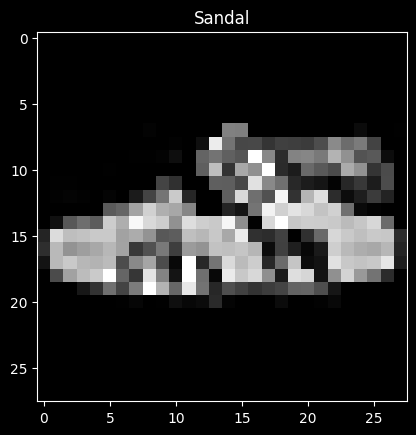

In [10]:
torch.manual_seed(42)
images, label = next(iter(train_dataloader))
i = 0
images[i], label[i]
from matplotlib import pyplot as plt

plt.imshow(images[i].squeeze(), cmap='gray')
plt.title(train_data.classes[label[i]])

In [11]:
ylogits = model(images[i].unsqueeze(0).to(device))

In [12]:
ylogits.argmax(dim=1), label[i]

(tensor([9], device='cuda:0'), tensor(5))

In [13]:
torch.softmax(ylogits, dim=1).argmax(dim=1), label[i]

(tensor([9], device='cuda:0'), tensor(5))

In [14]:
from functions import accuracy_fn

accuracy_fn(model(images.to(device)).argmax(dim=1).to(device), label.to(device))

9.375

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr= 0.005)
epochs = 3
model = model.to(device)

In [16]:
from training_model_fun import *
from time_calc import *


start_time = timer()
for epoch in range(epochs):

    train_step(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        epoch=epoch,
        show_every=1
    )
    test_step(
        model=model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn,
        epoch=epoch,
        show_every=1
    )
endtime = timer()


Epoch: 1
------ train Acc = 82.84% || train Loss = 0.47214
------ test Acc = 85.82% || test Loss = 0.39085
Epoch: 2
------ train Acc = 87.60% || train Loss = 0.34204
------ test Acc = 87.48% || test Loss = 0.34762
Epoch: 3
------ train Acc = 88.45% || train Loss = 0.31658
------ test Acc = 87.38% || test Loss = 0.35576


In [17]:
print_train_time(start_time, endtime, device=device)

model Took 59.6104975s training on NVIDIA GeForce GTX 1650


59.6104975

In [18]:
eval_model(
    model=model,
    data_loader=test_dataloader,
    accuracy_fn=accuracy_fn,
    loss_fn=loss_fn
)


{'model_name': 'CNN_model',
 'model_loss': 0.3557649850845337,
 'model_acc': '87.38%'}

In [57]:
predicted_value, real_value = [], []


with torch.inference_mode():
    for x, y in (test_dataloader):
        real_value.append(y.to('cpu'))
        x, y = x.to(device), y.to(device)
        predictions  = model(x).argmax(dim=1)
        ypres = predicted_value.append(predictions.to('cpu'))

real_value = torch.cat(real_value)
predicted_value = torch.cat(predicted_value)


In [71]:
import pandas as pd
predictions = pd.DataFrame({'True Value': real_value, 'Predicted Value': predicted_value})
predictions

,True Value,Predicted Value
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
...,...,...
9995,9,9
9996,1,1
9997,8,8
9998,1,1


In [72]:
classes = train_data.class_to_idx 
classes = {v:k for k, v in classes.items()}
classes[0]

'T-shirt/top'

In [73]:
#predictions['True Value'] = predictions['True Value'].apply(lambda x: classes[x])
#predictions['Predicted Value'] = predictions['Predicted Value'].apply(lambda x: classes[x])

In [74]:
predictions

,True Value,Predicted Value
0,9,9
1,2,2
2,1,1
3,1,1
4,6,6
...,...,...
9995,9,9
9996,1,1
9997,8,8
9998,1,1


In [83]:
real_value , predicted_value

real_value == test_data.targets

tensor([True, True, True,  ..., True, True, True])

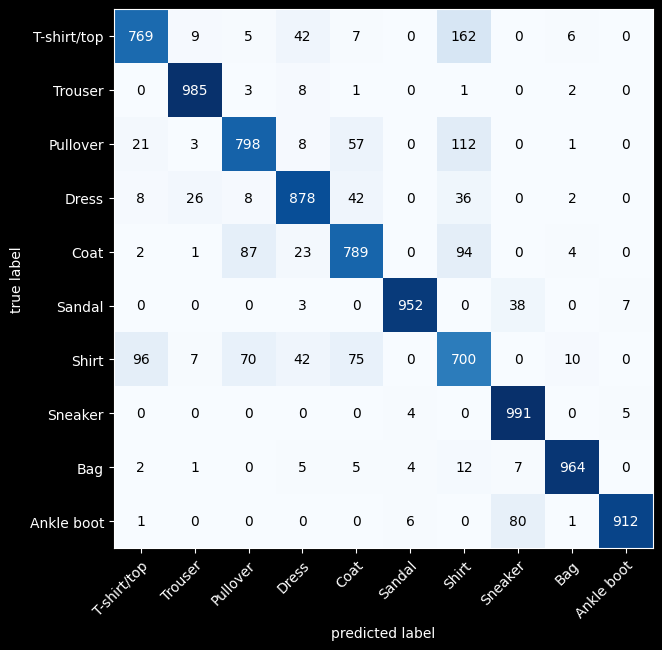

In [99]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix


confmat = ConfusionMatrix(task = 'multiclass', num_classes = len(test_data.class_to_idx))
conf_mat = confmat(predicted_value, test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=conf_mat.numpy(),
    class_names=test_data.classes,
    figsize=(10,7),
    colorbar= False,
    hide_spines=False,
    hide_ticks=False
)

## Saving a model


In [110]:
def save_model(
    model: torch.nn.Module,
    name: str,
    direcorty: str = "models",
    extenstion: str = "pth",
):
    """_summary_
        A function that saves model parameter in `pt` or `pth`
    Args:
        `model` (torch.nn.Module): Model class
        `name` (str) : Name of the file/model
        `direcorty` (str, optional) : Directory that should have the model pth or pt file. Defaults to 'models'.
        `extenstion` (str, optional) : extension of the model saved file can be either `pt` or `pth`. Defaults to 'pth'.
    """
    from pathlib import Path
    from torch import save

    # * Create direcoty path
    path = Path("models")
    path.mkdir(parents=True, exist_ok=True)

    # * create save path
    name = name +"."+ extenstion
    save_path = path / name
    print(f"saving model to {save_path}")
    save(obj=model.state_dict(), f=save_path)


In [109]:
save_model(model=model, name="cnn_model")


saving model to models\cnn_model.pth


In [116]:
#loaded_model = torch.load("models/cnn_model.pth")
loaded_model = CNN_model(
    n_channels=1, # 1 for grayscale images
    n_filters= 10, # number of filters
    n_classes= len(train_data.class_to_idx) # number of classes
)
loaded_model.load_state_dict(torch.load("models/cnn_model.pth"))

<All keys matched successfully>